In [9]:
# Imports

In [11]:
import sys, os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from src.utils.preprocess import get_data_generators, load_isic_data, compute_class_weights_from_names
from src.model.model import build_model, compile_model, fine_tune_model, get_gradcam_heatmap

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

In [13]:
# Configuration variables

In [14]:
DATA_DIR = '../data/ISIC2018_Task3_Training_Input'
CSV_FILE = '../data/ISIC2018_Task3_Training_GroundTruth.csv'  # ensure path / filename matches your repo
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [19]:
# load & inspect dataset distribution

Class names: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Total images: 10015


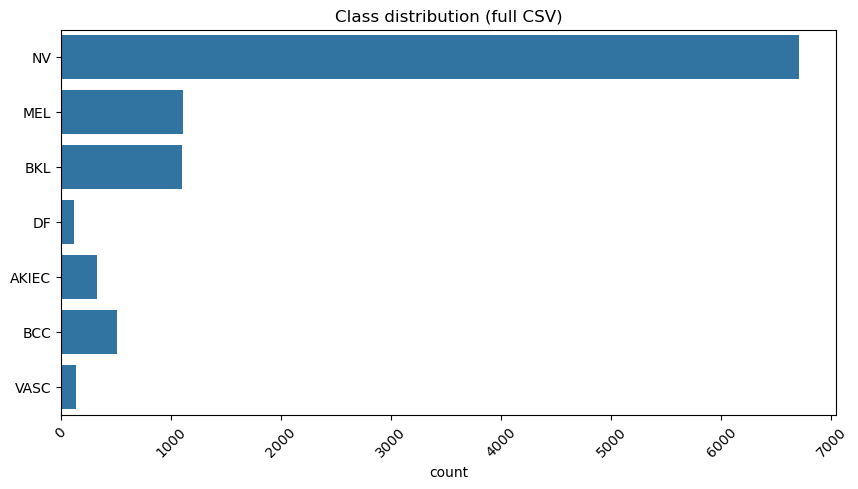

In [21]:
image_paths, label_indices, label_names, class_names = load_isic_data(DATA_DIR, CSV_FILE)
print(f'Class names: {class_names}')
print('Total images:', len(image_paths))

plt.figure(figsize=(10,5))
sns.countplot(label_names)
plt.xticks(rotation=45)
plt.title('Class distribution (full CSV)')
plt.show()

In [23]:
train_generator, val_generator, class_names = get_data_generators(DATA_DIR, CSV_FILE, img_size=IMG_SIZE, batch_size=BATCH_SIZE, subset_frac=None, seed=SEED)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [25]:
# check generator mapping

In [27]:
print('Train class indices:', train_generator.class_indices)
print('Num train steps per epoch:', train_generator.samples // BATCH_SIZE)
print('Num val steps:', val_generator.samples // BATCH_SIZE)

Train class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
Num train steps per epoch: 250
Num val steps: 62


In [29]:
# Compute class weights using the fixed snippet

In [ ]:
inv_map = {v:k for k,v in train_generator.class_indices.items()}

y_train_names = []
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))

for i, (_, y_batch) in enumerate(train_generator):
    indices = np.argmax(y_batch, axis=1)
    y_train_names.extend([inv_map[i] for i in indices])
    if i + 1 >= steps_per_epoch:
        break

y_train_names = y_train_names[:train_generator.samples]

class_weights = compute_class_weights_from_names(y_train_names)
print('Class weights dict (index->weight):', class_weights)

In [33]:
# Build & compile model 

In [34]:
num_classes = len(class_names)
model = build_model(num_classes=num_classes, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
model = compile_model(model, learning_rate=1e-4)
model.summary()

Model: "efficientnetb0_skin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,380,330 (16.71 MB)

 Trainable params: 330,247 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [3]:
# Callbacks 

In [5]:
ckpt_path = '../models/skin_lesion_model.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    CSVLogger('../models/training_log.csv')
]

NameError: name 'EarlyStopping' is not defined

In [7]:
# Initial training (feature extraction)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks,
    workers=4,
    use_multiprocessing=False
)

In [ ]:
# fine-tune: unfreeze tail of backbone and lower lr 

In [ ]:
model = fine_tune_model(model, trainable_layers=30)
model = compile_model(model, learning_rate=1e-5)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks,
    workers=4,
    use_multiprocessing=False
)

In [ ]:
# --- evaluation: get predictions on validation generator ---
val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
val_preds = model.predict(val_generator, steps=val_steps)
val_pred_indices = np.argmax(val_preds, axis=1)
val_true = val_generator.classes 

In [ ]:
 # reorder class names to match val_generator.class_indices order
index_to_class = {v:k for k,v in val_generator.class_indices.items()}
ordered_class_names = [index_to_class[i] for i in range(len(index_to_class))]

cm = confusion_matrix(val_true, val_pred_indices)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ordered_class_names, yticklabels=ordered_class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(val_true, val_pred_indices, target_names=ordered_class_names, zero_division=0))

In [ ]:
# --- training curves ---
def plot_history(h1, h2=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'], label='train_acc')
    plt.plot(h1.history['val_accuracy'], label='val_acc')
    if h2 is not None:
        plt.plot(h2.history.get('accuracy', []), label='fine_train_acc')
        plt.plot(h2.history.get('val_accuracy', []), label='fine_val_acc')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'], label='train_loss')
    plt.plot(h1.history['val_loss'], label='val_loss')
    if h2 is not None:
        plt.plot(h2.history.get('loss', []), label='fine_train_loss')
        plt.plot(h2.history.get('val_loss', []), label='fine_val_loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history, history_fine)